# LEP vs shower time
This is a tricky case.  LEP is often 20 minutes after shower, but only after a certain time (8pm ish?).  Looking for ways to discover this 2D relationship, in a way I can apply to other data.  Visualisations, ML, etc.

In [67]:
import logging

import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd

from importlib import reload

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [69]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [182]:
col1 = 'events:shower:lastSSM'
col2 = 'circadian:combined:entries:LEP:datetimeSSM'
c1 = 'shower'
c2 = 'LEP'

columns_to_select = [col1, col2]

df = day_data.copy()[columns_to_select]
df.index = day_data['dayAndNightOf']
import notebooks.Util.Time as Time
reload(Time)
df = Time.convert_cols_to_hours(df)


df[c1] = df[col1.replace(':lastSSM', ':last')]
df[c2] = df[col2.replace(':datetimeSSM', ':datetime')]
df.drop(columns=[col1.replace(':lastSSM', ':last'), col2.replace(':datetimeSSM', ':datetime')], inplace=True)

# Circadian data just gets better here. As I'm doing morning walks.
df = df[df.index >= '2024-08-14']
df = df[df[c1].notna() & df[c2].notna()]
df['Diff'] = df[c1] - df[c2]


df.head()

,shower,LEP,Diff
dayAndNightOf,,,
2024-08-18,14.766667,22.366667,-7.600000
2024-08-26,15.416667,21.200000,-5.783333
2024-09-15,18.250000,21.400000,-3.150000
2024-09-18,21.166667,21.933333,-0.766667
2024-09-28,18.833333,21.866667,-3.033333


# Simple correlations

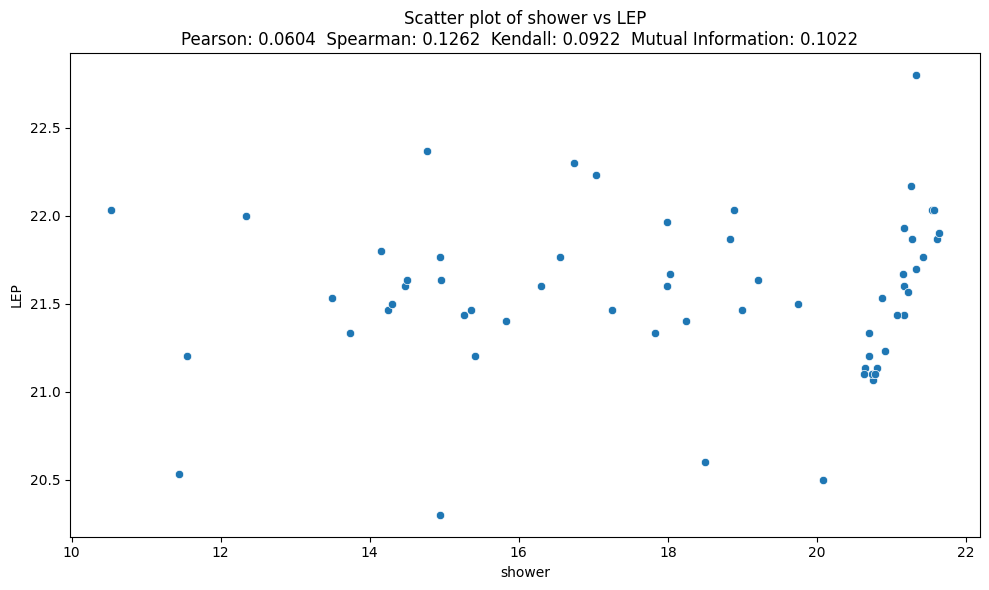

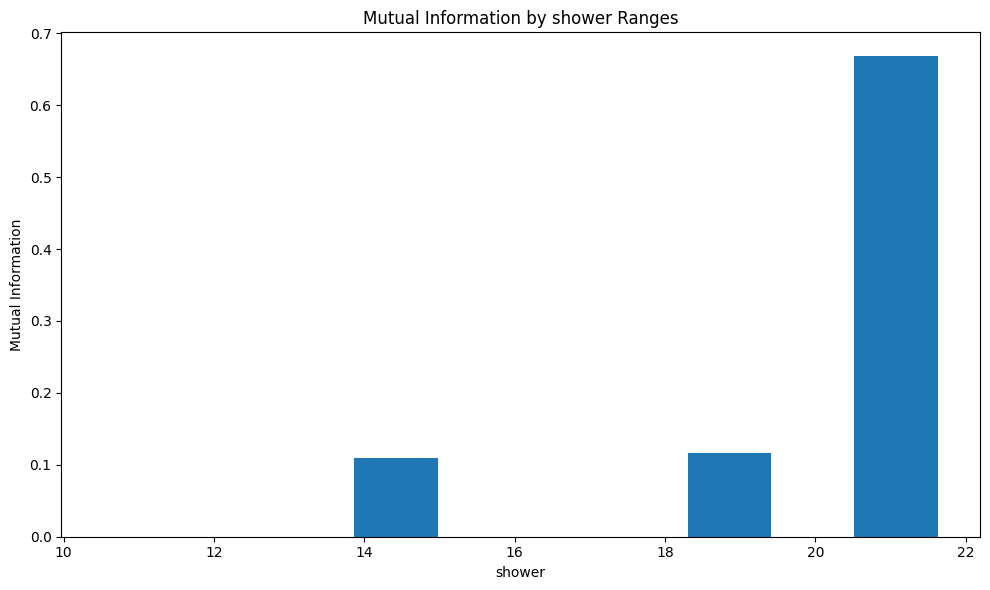

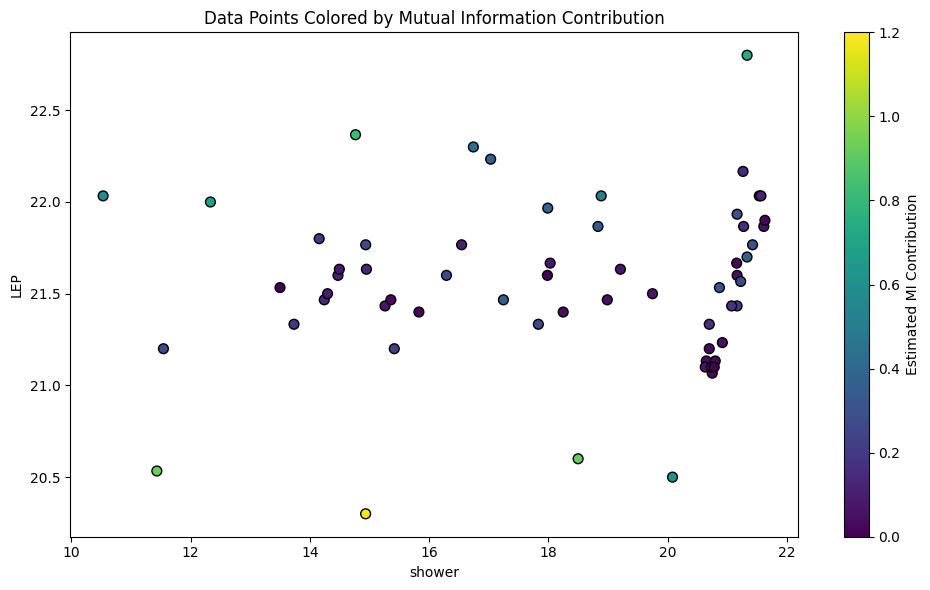

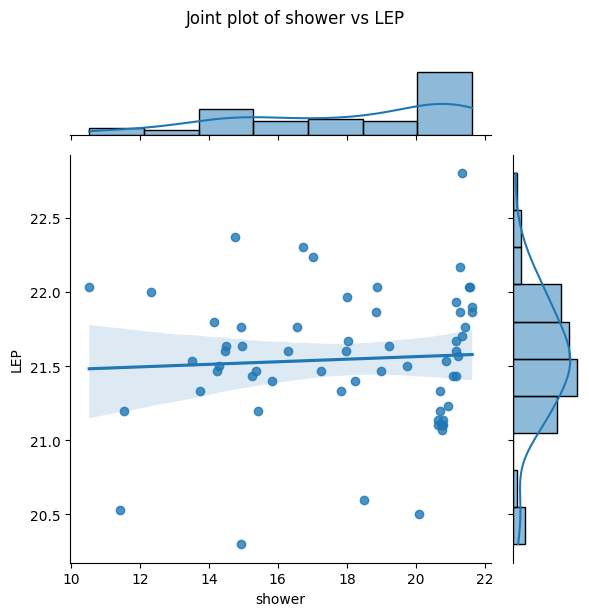

Pearson correlation: 0.0604, p-value: 0.6408
Spearman correlation: 0.1262, p-value: 0.3285
Kendall correlation: 0.0922, p-value: 0.2956
Mutual Information: 0.1022


In [183]:
import stats_two_variables
reload(stats_two_variables)

results = stats_two_variables.calculate_correlations(df, c1, c2)
stats_two_variables.visualize_scatter(df, c1, c2, results)
stats_two_variables.visualize_joint_plot(df, c1, c2)
stats_two_variables.print_correlation_results(results)

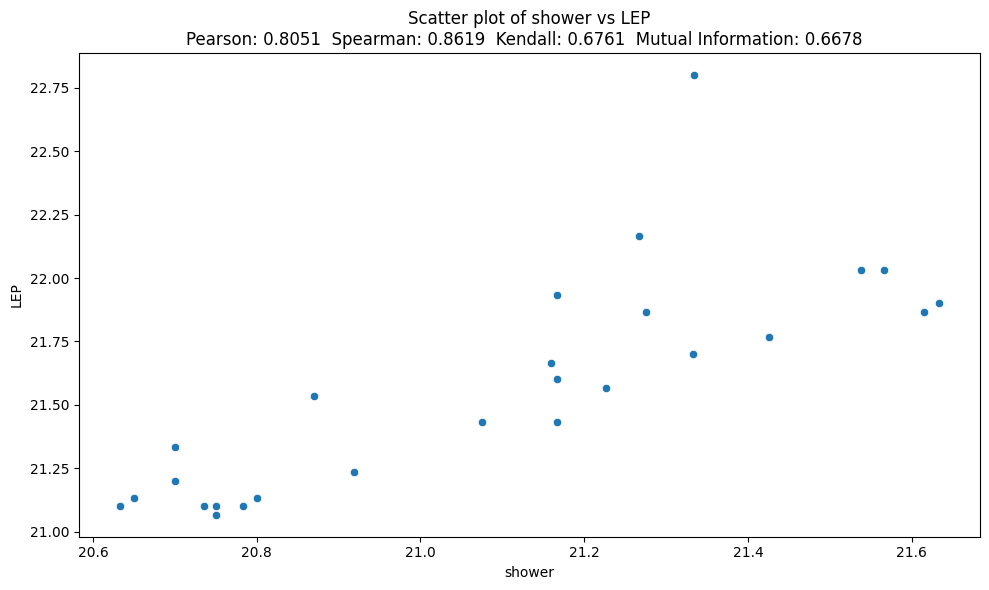

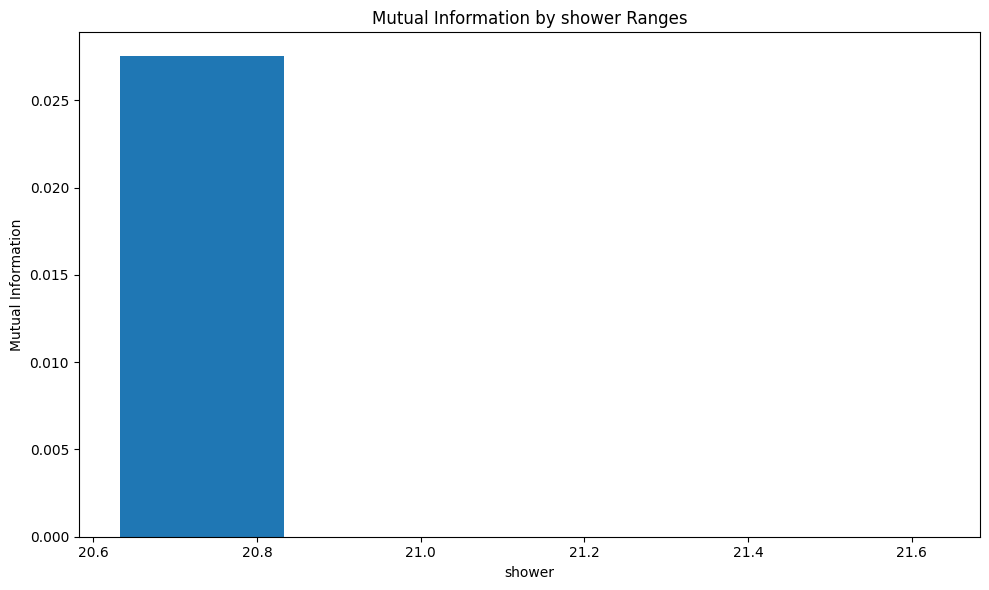

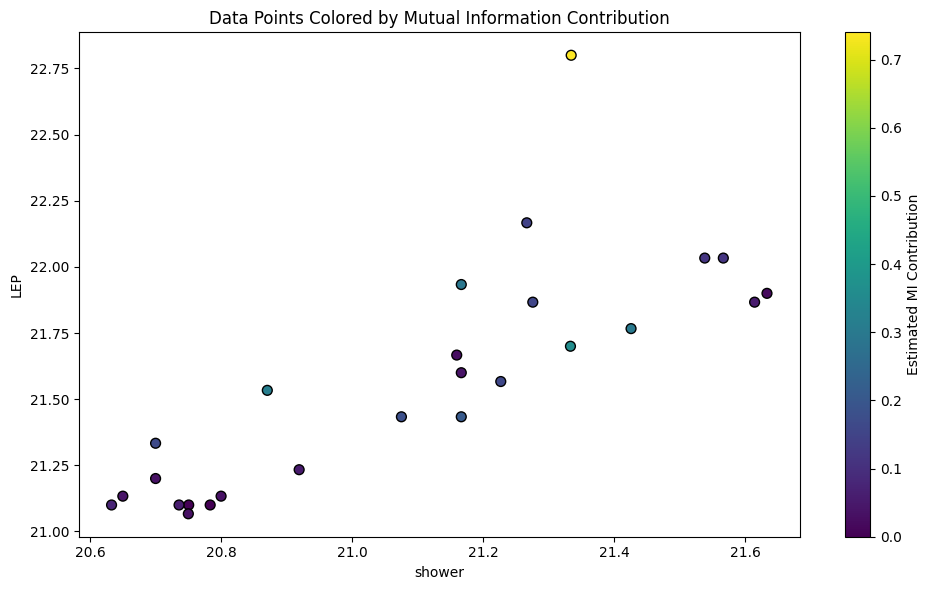

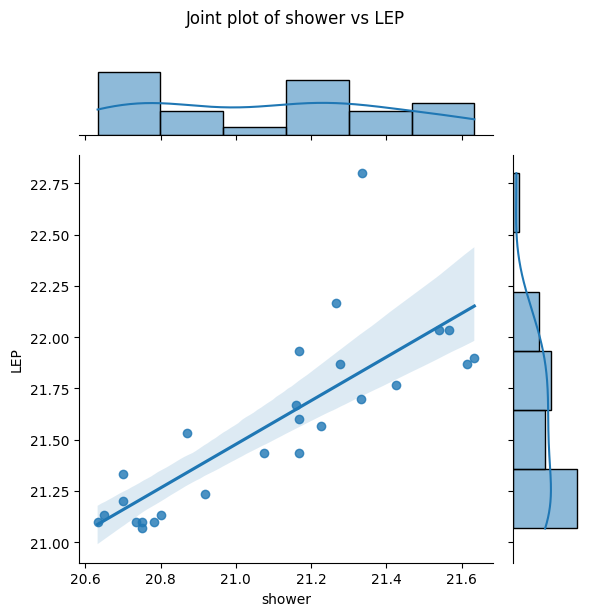

{'Pearson': {'correlation': np.float64(0.8050694273924396),
  'p_value': np.float64(7.067983826442344e-07)},
 'Spearman': {'correlation': np.float64(0.8619458046243965),
  'p_value': np.float64(1.5360984557625803e-08)},
 'Kendall': {'correlation': np.float64(0.6761307172968649),
  'p_value': np.float64(1.9468068129776805e-06)},
 'Mutual Information': {'score': np.float64(0.6678390802848622)}}

In [184]:
# After 8pm
df_after_8 = df[df['shower'] >= 20.25]
results = stats_two_variables.calculate_correlations(df_after_8, c1, c2)
stats_two_variables.visualize_scatter(df_after_8, c1, c2, results)
stats_two_variables.visualize_joint_plot(df_after_8, c1, c2)
results

# Look for horizontal threshold where linear model works better
Works great for shower vs LEP, probbly not for others

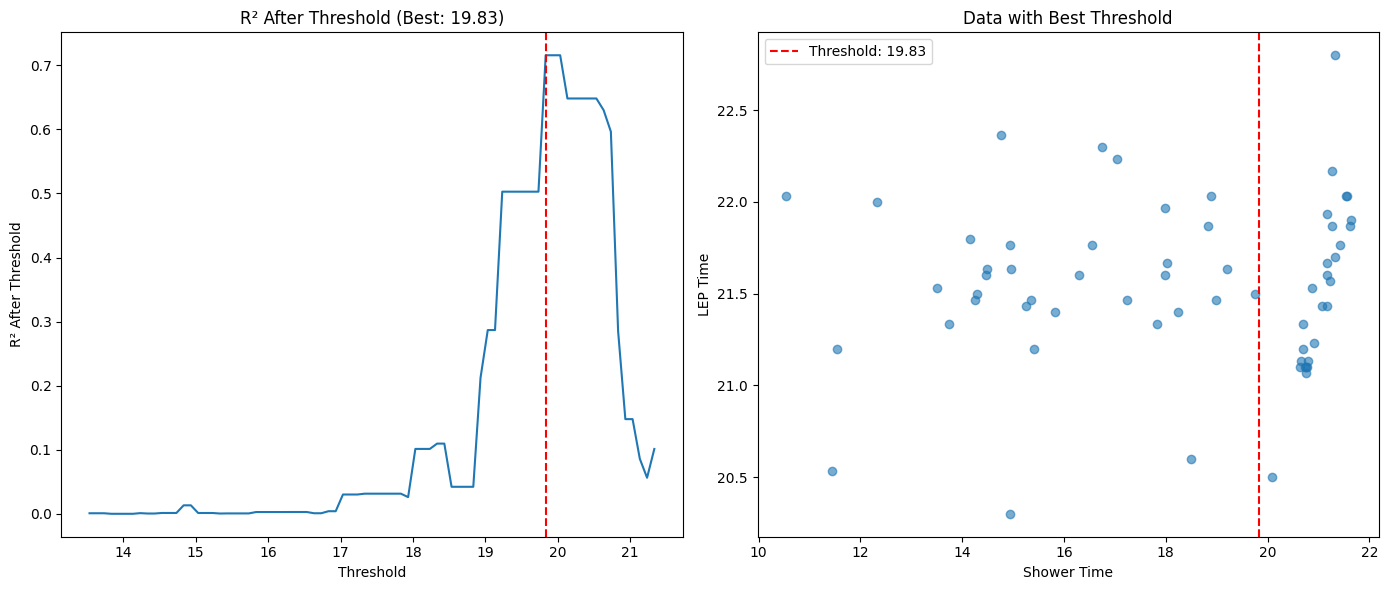

(np.float64(19.8333333333333),
     threshold  points_after  points_before  r2_after  mean_after  std_after
 0   13.533333            57              5  0.001157   21.554971   0.437897
 1   13.633333            57              5  0.001157   21.554971   0.437897
 2   13.733333            57              5  0.001157   21.554971   0.437897
 3   13.833333            56              6  0.000315   21.558929   0.440778
 4   13.933333            56              6  0.000315   21.558929   0.440778
 ..        ...           ...            ...       ...         ...        ...
 74  20.933333            15             47  0.147979   21.851111   0.329953
 75  21.033333            15             47  0.147979   21.851111   0.329953
 76  21.133333            14             48  0.086041   21.880952   0.321384
 77  21.233333             9             53  0.056551   22.014815   0.308765
 78  21.333333             7             55  0.101426   22.014286   0.340801
 
 [79 rows x 6 columns])

In [185]:
import stats_two_variables
reload(stats_two_variables)

X = df[c1].values.reshape(-1, 1)
y = df[c2].values

stats_two_variables.find_optimal_threshold(X, y)

# Machine learning

Outlier removal: removed 6 points (9.7%), R² improved from 0.2630 to 0.4930
Decision Tree Rules:
|--- shower <= 21.25
|   |--- shower <= 19.92
|   |   |--- value: [21.64]
|   |--- shower >  19.92
|   |   |--- value: [21.25]
|--- shower >  21.25
|   |--- shower <= 21.38
|   |   |--- value: [22.28]
|   |--- shower >  21.38
|   |   |--- value: [21.92]



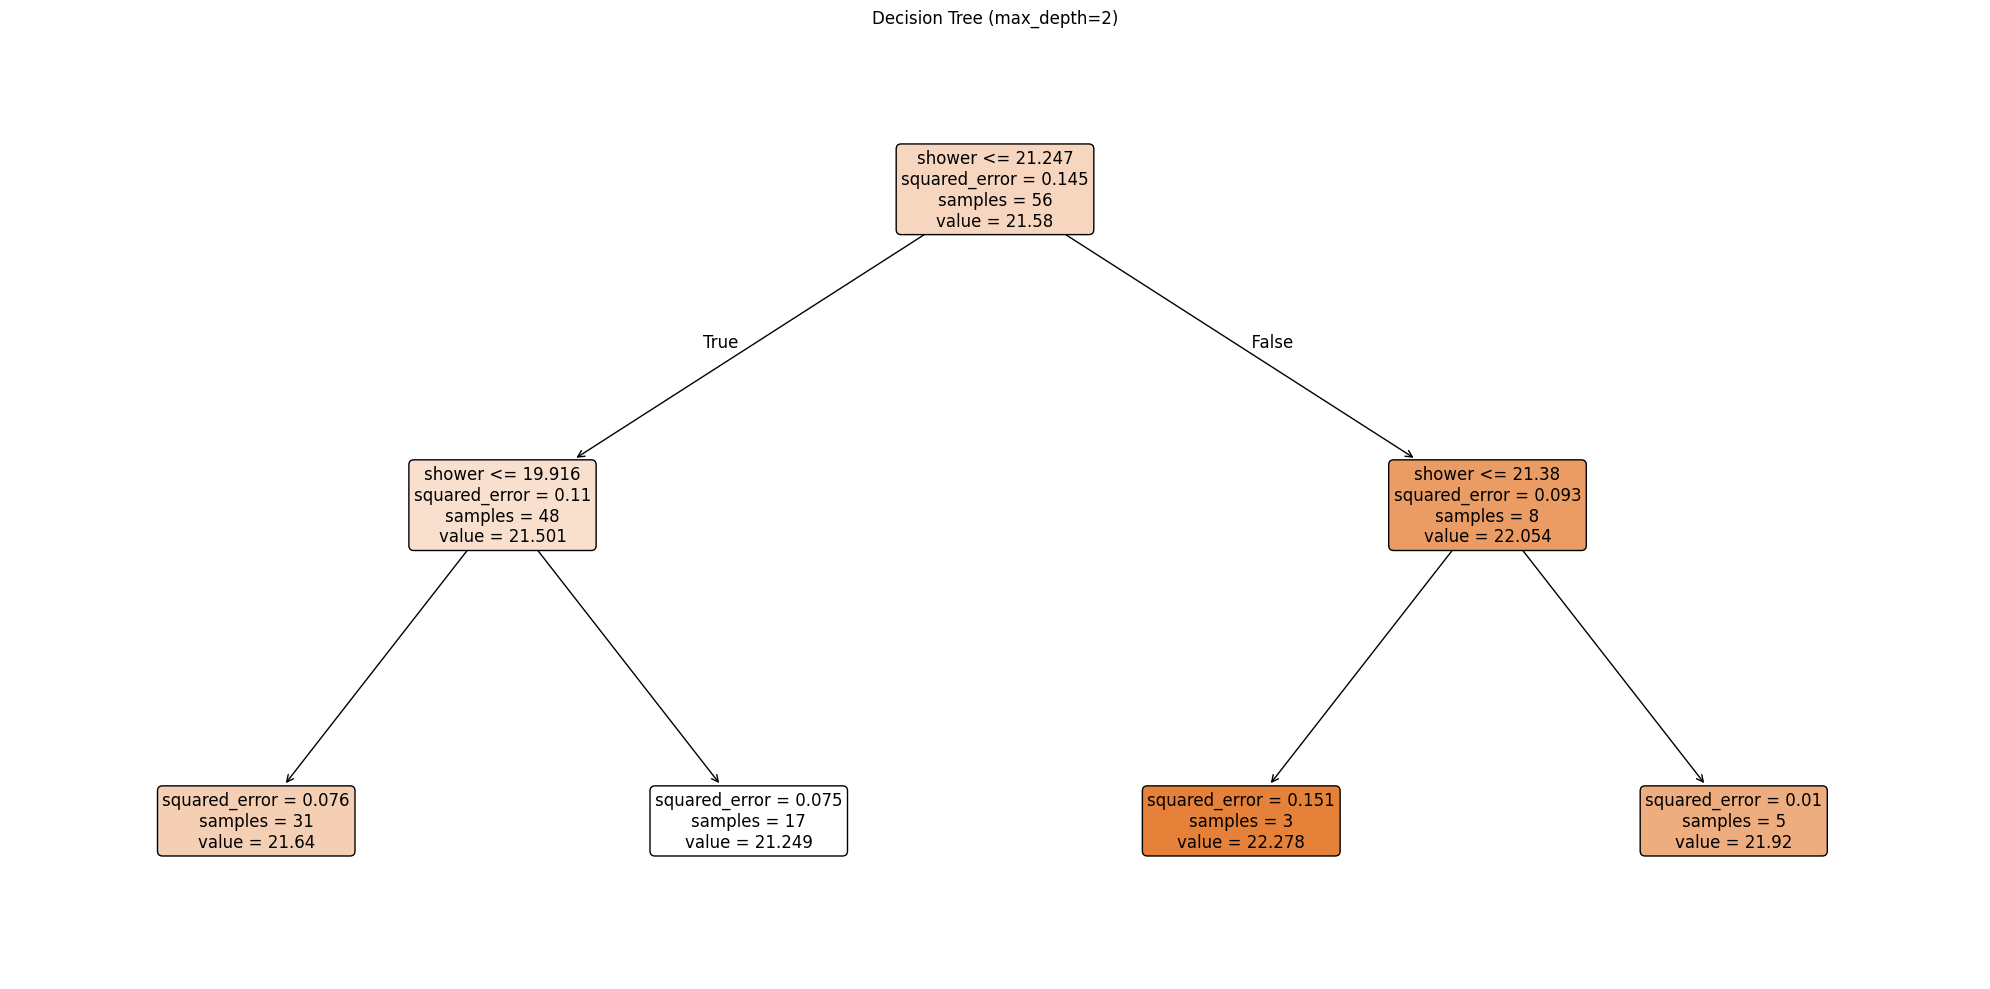

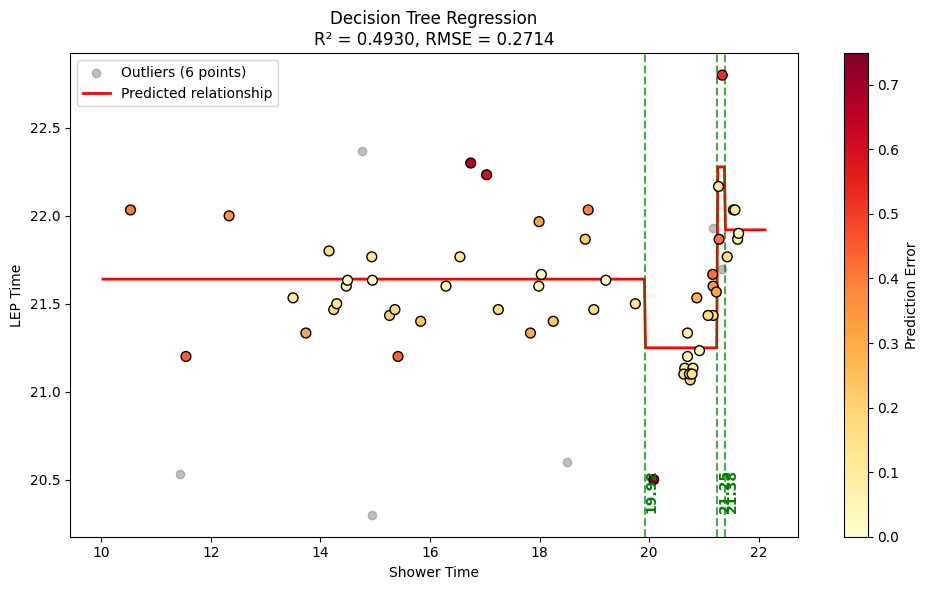

Using 2D clustering on both shower and LEP
Finding optimal subsets for Decision Tree...


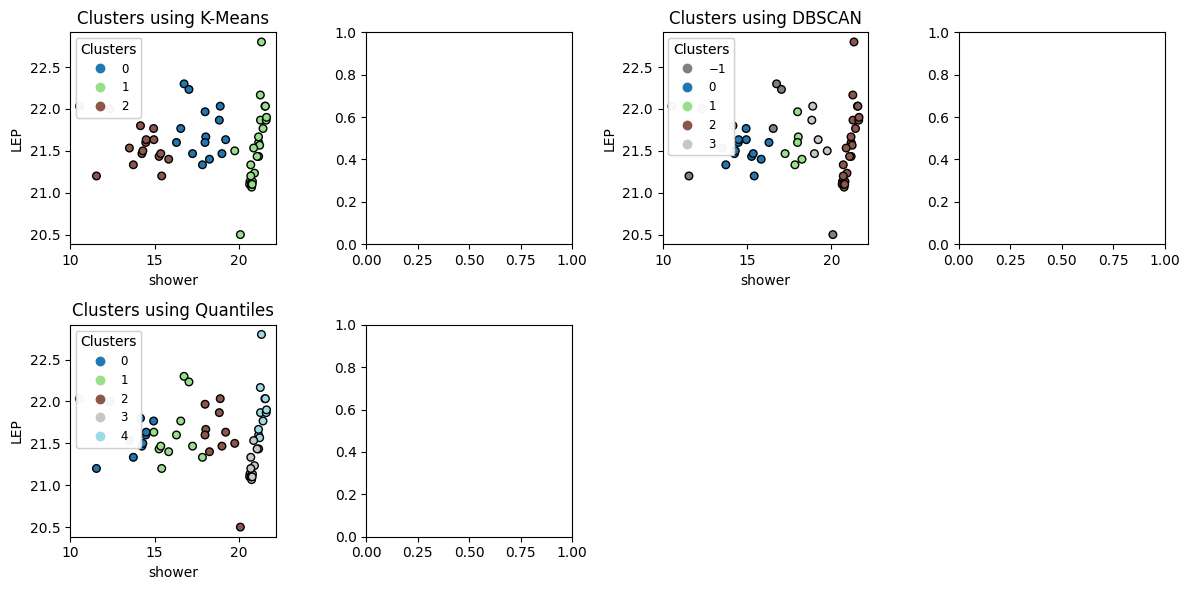

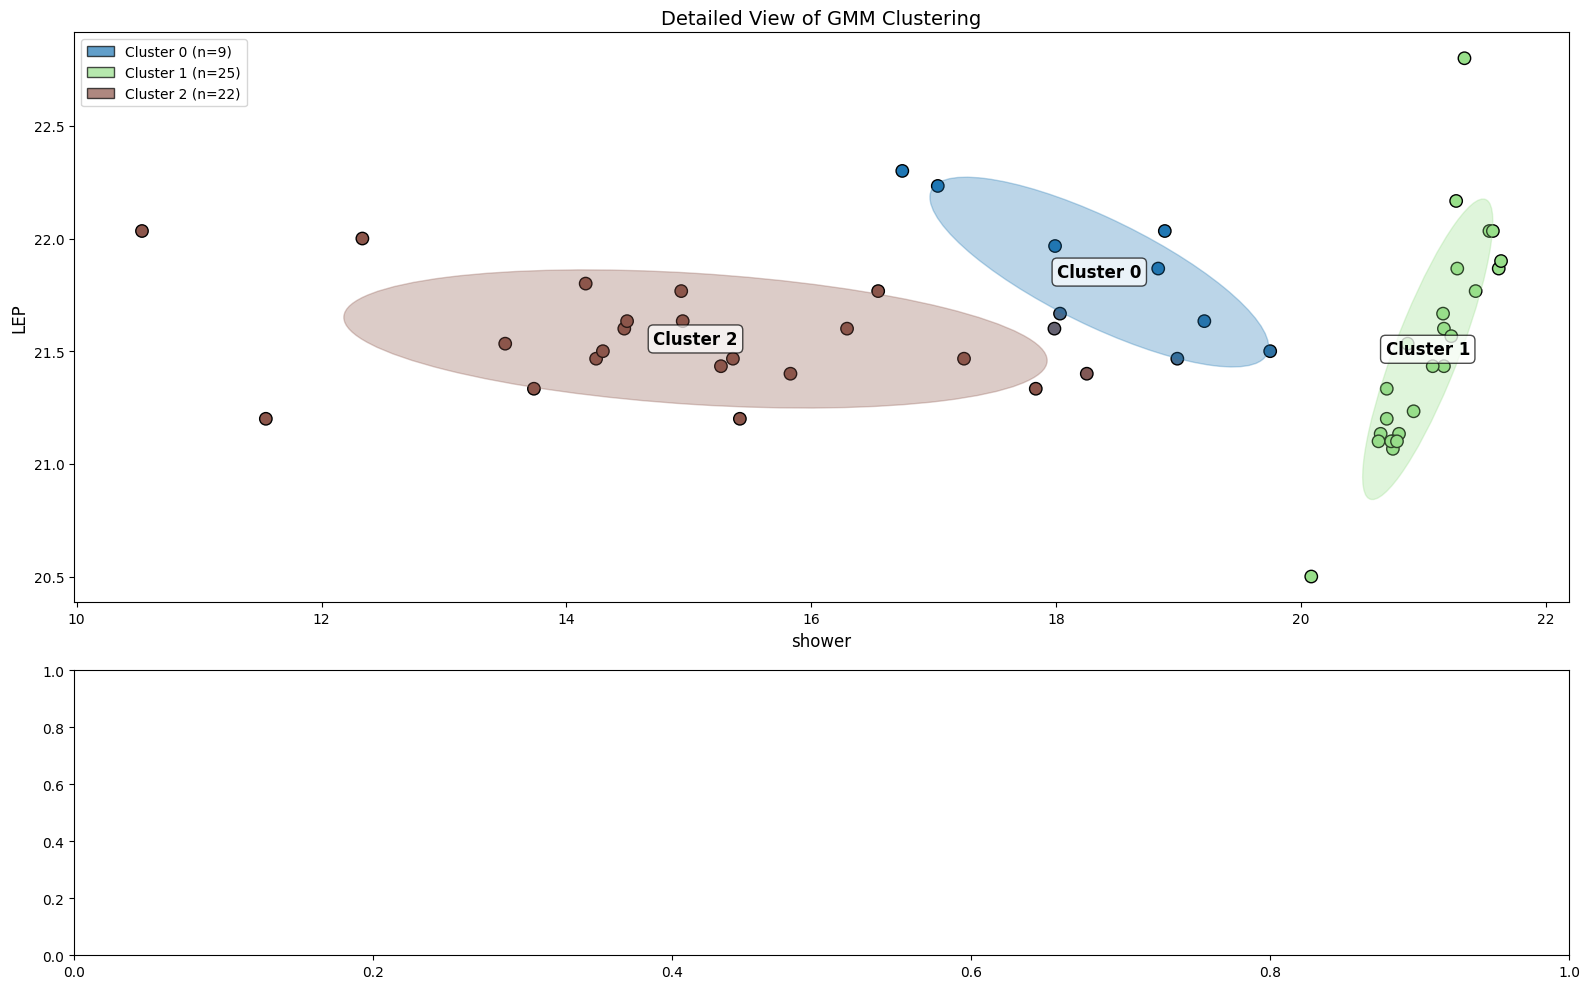

Decision Tree Regression Results:
R² score: 0.4930
RMSE: 0.2714
Outliers removed: 6 points (9.7%)


In [195]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_decision_tree_regressor(df, c1, c2, max_depth=2)

Outlier removal: removed 1 points (1.6%), R² improved from 0.8189 to 0.9796


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\skle

Best Gaussian Process Kernel: Matern
Optimized kernel parameters: 0.964**2 * Matern(length_scale=1e-05, nu=1.5)


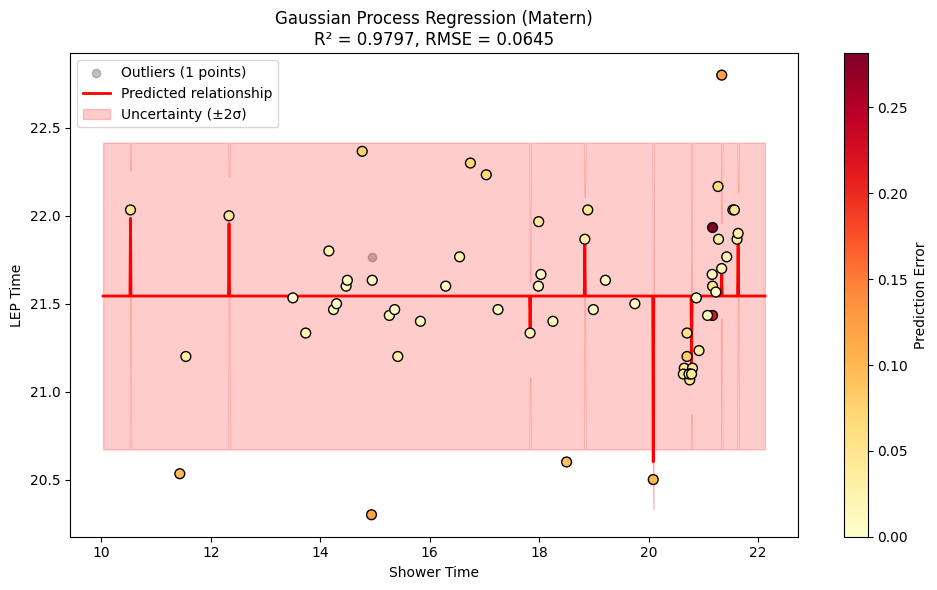

Using 2D clustering on both shower and LEP
Finding optimal subsets for Gaussian Process...
Gaussian Process Regression Results (Kernel: Matern):
R² score: 0.9797
RMSE: 0.0645
Outliers removed: 1 points (1.6%)


<Figure size 1400x800 with 0 Axes>

In [187]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_gaussian_process_regressor(df, c1, c2)

Outlier removal: removed 6 points (9.7%), R² improved from 0.1909 to 0.3431


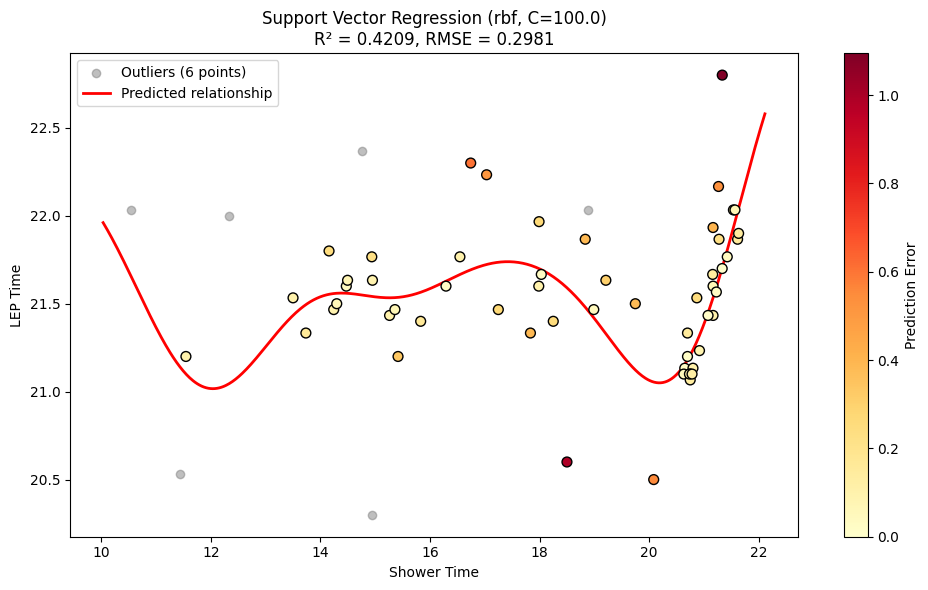

Using 2D clustering on both shower and LEP
Finding optimal subsets for SVR...
SVR Results (kernel=rbf, C=100.0):
R² score: 0.4209
RMSE: 0.2981
Outliers removed: 6 points (9.7%)


<Figure size 1400x800 with 0 Axes>

In [188]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_svr(df, c1, c2)

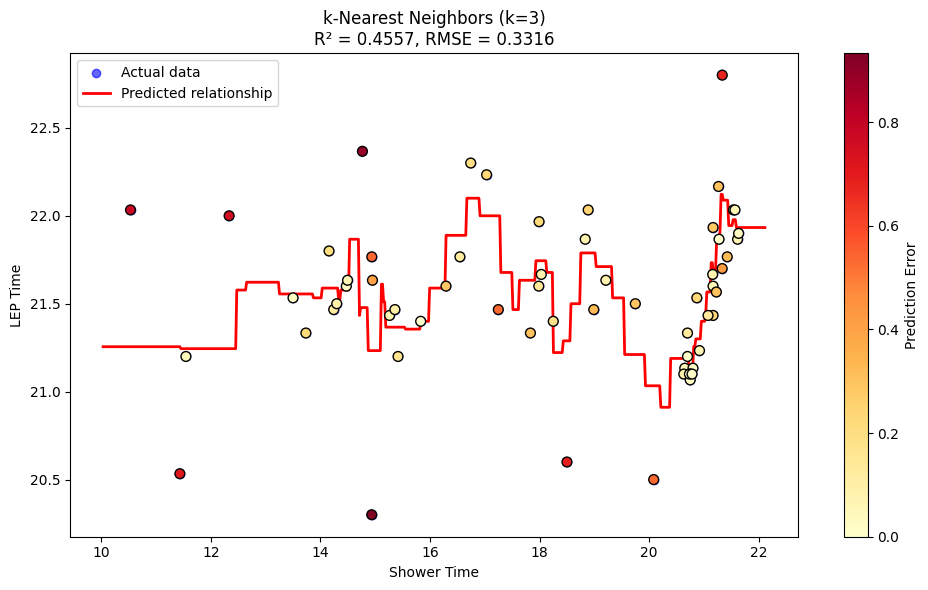

Using 2D clustering on both shower and LEP
Finding optimal subsets for k-NN...
k-NN Regression Results (k=3):
R² score: 0.4557
RMSE: 0.3316


<Figure size 1400x800 with 0 Axes>

In [189]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_knn_regressor(df, c1, c2)




Random Forest Feature Importance: 1.0000


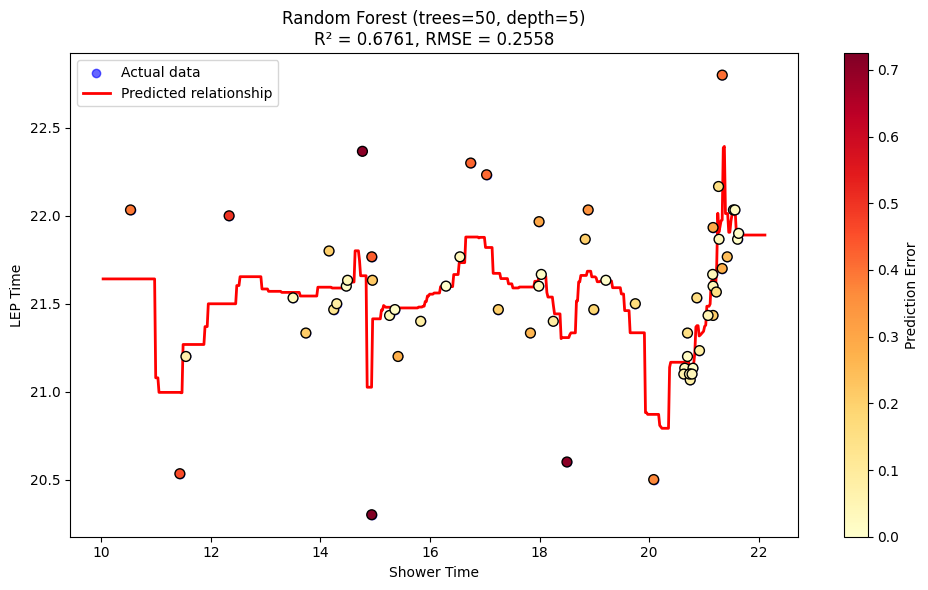

Using 2D clustering on both shower and LEP
Finding optimal subsets for Random Forest...
Random Forest Regression Results (trees=50, depth=5):
R² score: 0.6761
RMSE: 0.2558


<Figure size 1400x800 with 0 Axes>

In [190]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_random_forest_regressor(df, c1, c2)


In [197]:
from pysr import PySRRegressor

df2 = df.copy().drop(columns=['Diff'])
df2.columns = df2.columns.str.replace(':', '_')
X = df2.drop(columns=['LEP'])
y = df2['LEP']

model = PySRRegressor(niterations=30, progress=True)
model.fit(X, y)


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.020e-01  1.594e+01  y = 21.547
5           2.013e-01  9.147e-04  y = 21.391 - (shower * -0.0086432)
7           1.831e-01  4.726e-02  y = 21.557 - (0.044921 / (shower + -11.39))
9           1.825e-01  1.739e-03  y = 21.591 - ((shower / 134.54) / (shower + -11.351))
11          1.825e-01  1.100e-05  y = 21.591 - (((shower - -0.20442) / 134.54) / (shower + -...
                                      11.351))
17          1.823e-01  1.490e-04  y = (shower / ((((shower - -0.6407) + (-263.39 / shower)) ...
                                      + shower) * (-263.5 / shower))) - -21.629
19          1.823e-01  8.482e-05  y = (shower / ((((((shower - -0.54548) + (-263.4 / shower)...
                                      ) + shower) * -263.5) / shower) * 1.2377)) - -21.618
25          1.821e-01  1.265e-04  y = ((-12.094 - ((shower - (shower - 

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score  \
	0        0.000000   
	1        0.000915   
	2  >>>>  0.047256   
	3        0.001739   
	4        0.000011   
	5        0.000149   
	6        0.000085   
	7        0.000127   
	
	                                                                                                                                                         equation  \
	0                                                                                                                                                       21.547327   
	1                                                                                                                             21.390818 - (shower * -0.008643209)   
	2                                                                                                               21.557262 - (0.044921096 / (shower + -11.389829))   
	3                                                                                                      21.59113 - ((shower / 134.53908) / (shower + -11.3511715))   
	4                                                                                       21.59113 - (((shower - -0.20441878) / 134.53908) / (shower + -11.350895))   
	5                                                      (shower / ((((shower - -0.6407028) + (-263.3941 / shower)) + shower) * (-263.4994 / shower))) - -21.628883   
	6                                        (shower / ((((((shower - -0.5454844) + (-263.3962 / shower)) + shower) * -263.49927) / shower) * 1.2377373)) - -21.61752   
	7  ((-12.093508 - ((shower - (shower - -6.75502)) - shower)) / ((((shower - -0.016106954) + (-257.6466 / (shower + shower))) * -352.3034) / shower)) - -21.632362   
	
	       loss  complexity  
	0  0.201991           1  
	1  0.201253           5  
	2  0.183103           7  
	3  0.182468           9  
	4  0.182464          11  
	5  0.182300          17  
	6  0.182270          19  
	7  0.182131          25  
]

  - outputs\20250421_161825_WazZH5\hall_of_fame.csv


In [198]:
import pandas as pd

equation_df = model.equations_
print(equation_df[['equation', 'loss', 'complexity']])


                                                                                                                                                         equation  \
0                                                                                                                                                       21.547327   
1                                                                                                                             21.390818 - (shower * -0.008643209)   
2                                                                                                               21.557262 - (0.044921096 / (shower + -11.389829))   
3                                                                                                      21.59113 - ((shower / 134.53908) / (shower + -11.3511715))   
4                                                                                       21.59113 - (((shower - -0.20441878) / 134.53908) / (shower + -11.350895))   
5         

In [199]:
feature_list = df.columns
mapping = {f'x{i}': name for i, name in enumerate(feature_list)}

import re

def replace_vars(equation, mapping):
    for k, v in mapping.items():
        equation = re.sub(rf'\b{k}\b', v, equation)
    return equation

readable_eqs = [replace_vars(eq, mapping) for eq in model.equations_["equation"]]
readable_eqs



['21.547327',
 '21.390818 - (shower * -0.008643209)',
 '21.557262 - (0.044921096 / (shower + -11.389829))',
 '21.59113 - ((shower / 134.53908) / (shower + -11.3511715))',
 '21.59113 - (((shower - -0.20441878) / 134.53908) / (shower + -11.350895))',
 '(shower / ((((shower - -0.6407028) + (-263.3941 / shower)) + shower) * (-263.4994 / shower))) - -21.628883',
 '(shower / ((((((shower - -0.5454844) + (-263.3962 / shower)) + shower) * -263.49927) / shower) * 1.2377373)) - -21.61752',
 '((-12.093508 - ((shower - (shower - -6.75502)) - shower)) / ((((shower - -0.016106954) + (-257.6466 / (shower + shower))) * -352.3034) / shower)) - -21.632362']

Failed to plot equation 8: 21.547327
Error: x and y must have same first dimension, but have shapes (300,) and (1,)


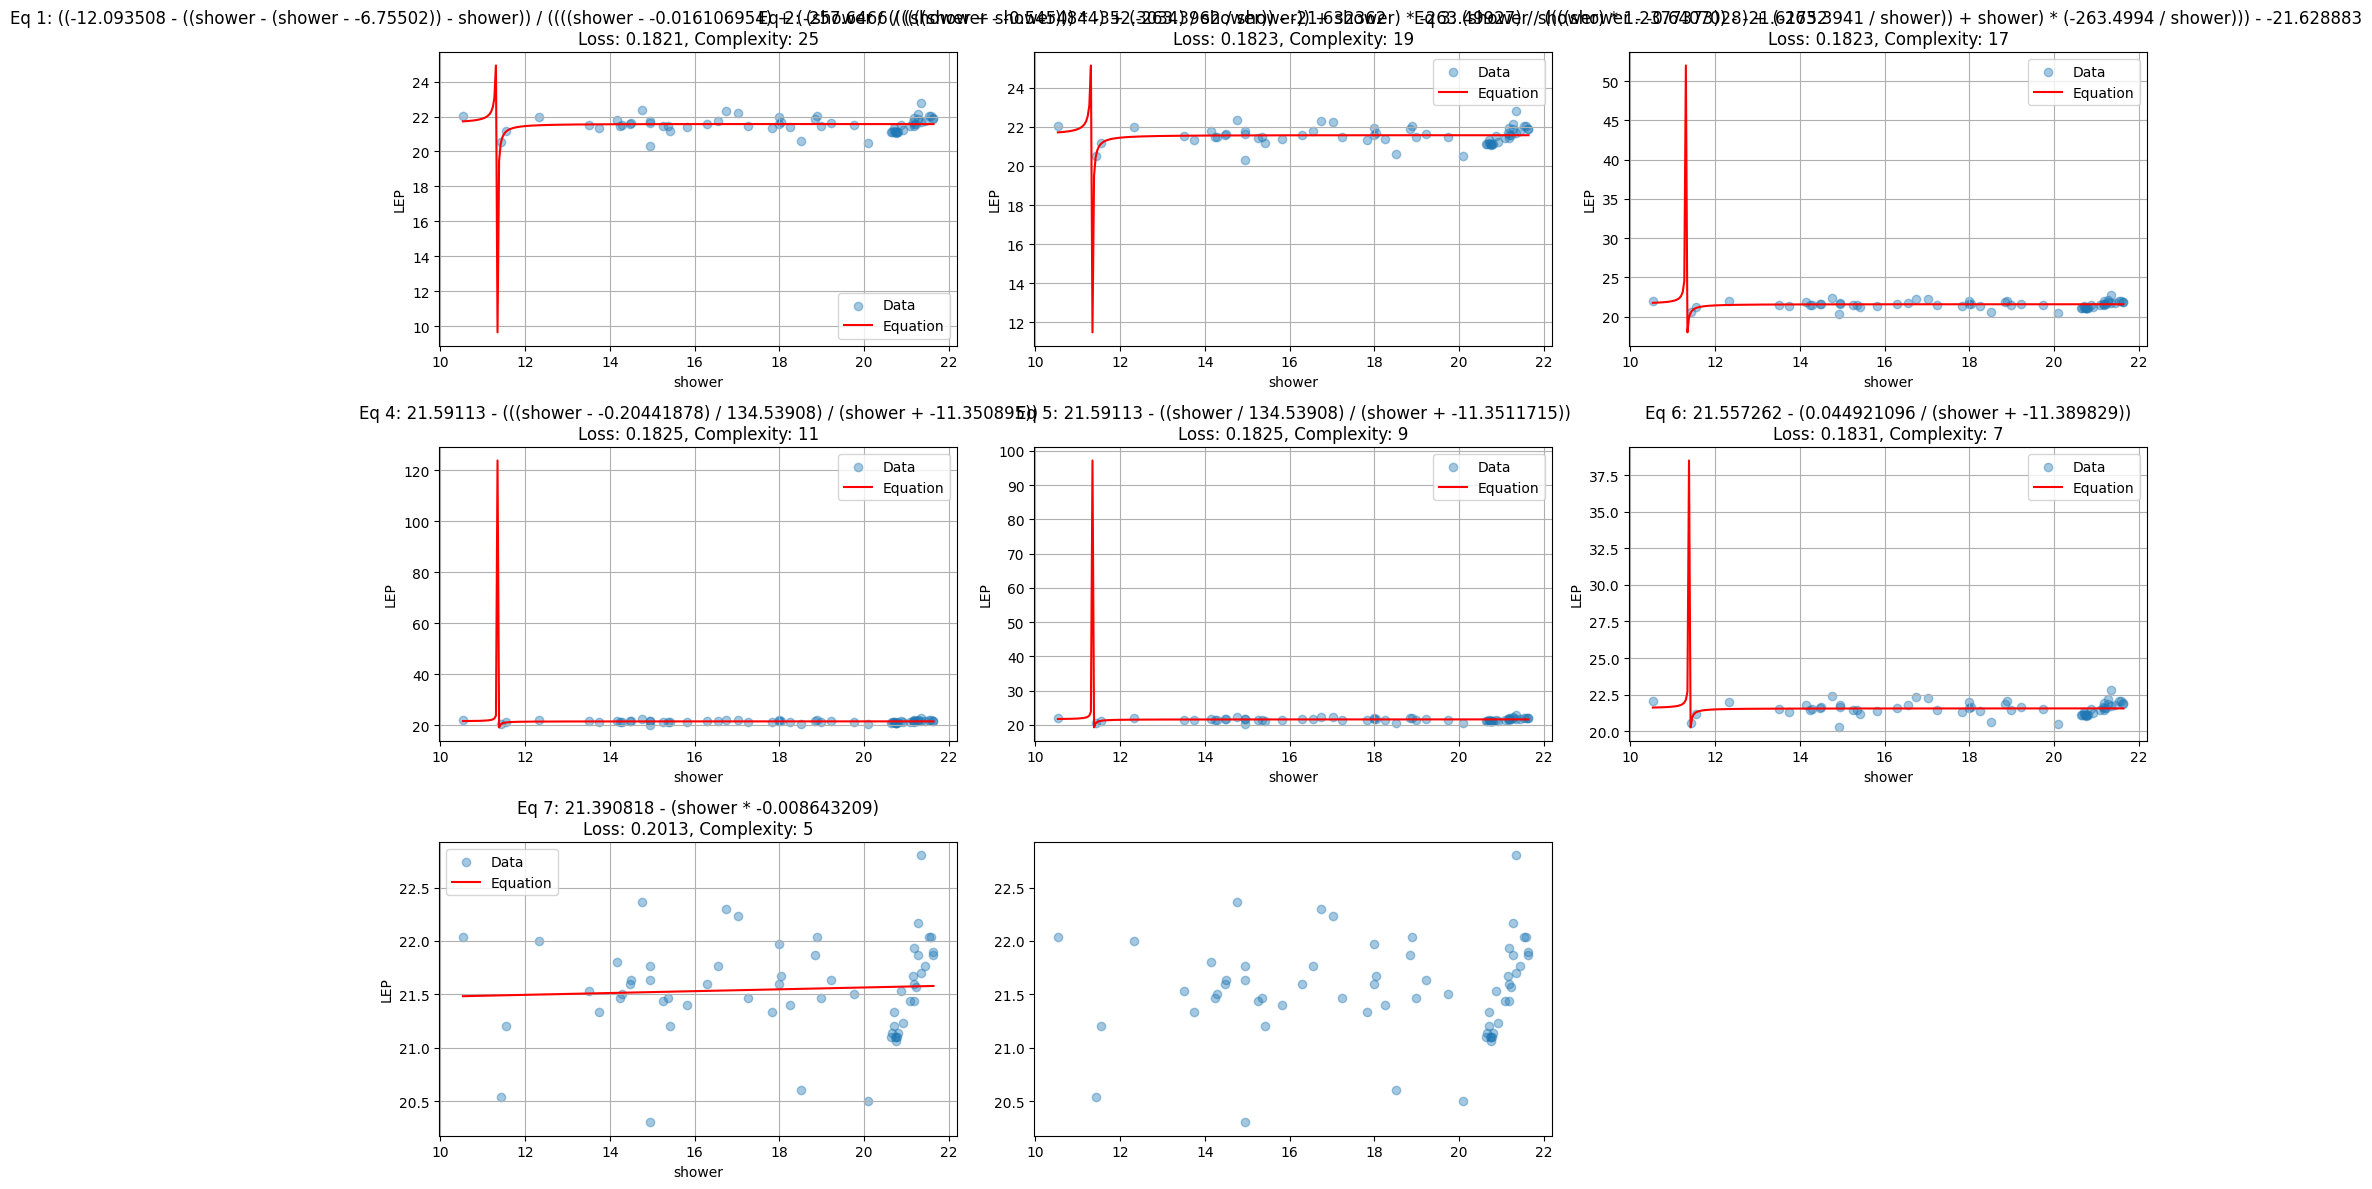

In [200]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
from sympy.utilities.lambdify import lambdify

# Make sure you have only one feature
feature = X.columns[0]
x_vals = np.linspace(X[feature].min(), X[feature].max(), 300)
x_df = pd.DataFrame({feature: x_vals})

# Sort and get the top 9 equations
top_equations = model.equations_.sort_values("loss").head(9)

# Define the sympy variable
x_sym = sp.Symbol(feature)

plt.figure(figsize=(18, 12))
for i, row in enumerate(top_equations.itertuples(), 1):
    try:
        # Convert string equation to sympy expression
        expr = sp.sympify(row.equation)
        func = lambdify(x_sym, expr, modules=["numpy"])
        y_vals = func(x_vals)

        # Plot
        plt.subplot(3, 3, i)
        plt.scatter(X[feature], y, alpha=0.4, label="Data")
        plt.plot(x_vals, y_vals, color='red', label="Equation")
        plt.title(f"Eq {i}: {row.equation}\nLoss: {row.loss:.4f}, Complexity: {row.complexity}")
        plt.xlabel(feature)
        plt.ylabel("LEP")
        plt.legend()
        plt.grid(True)
    except Exception as e:
        print(f"Failed to plot equation {i}: {row.equation}\nError: {e}")

plt.tight_layout()
plt.show()
